# ERA-Interim Data

Data processing scripts are in the `scripts/era_interim` folder.

Summary of data processing pipeline:

1. Download data from ECMWF (6-hourly analysis fields and 3-hourly forecast accumulations, on latitude-longitude grid)
2. Compute daily mean analysis fields.
3. Compute daily total forecast accumulations.
4. Create north pole Lambert azimuthal equal area (NPLAEA) grids for interpolating the lat-lon data. Try a couple of different resolutions (100 km and 200 km) for comparison.
5. Grid ERA-Interim daily fields onto NPLAEA grid.
6. Reshape the data for input to PCA and SOM.

The table below shows some of the potentially relevant ERA-Interim variables. 
- `label` is the label I use in my scripts and saved data files
- `code` is the code used in the data files from ECMWF
- Data types are:
  - `an`: analysis
  - `fc`: forecast

|  label    | long_name                                        | units                 |    code | data_type   |
|:------|:-------------------------------------------------|:----------------------|--------:|:------------|
| msl   | Mean sea level pressure                          | Pa                    | 151.128 | an          |
| viwve | Vertical integral of eastward water vapour flux  | kg m^-1 s^-1          |  71.162 | an          |
| viwvn | Vertical integral of northward water vapour flux | kg m^-1 s^-1          |  72.162 | an          |
| viwvd | Vertical integral of divergence of moisture flux | kg m^-2 s^-1          |  84.162 | an          |
| tcwv  | Total column water vapour                        | kg m^-2               | 137.128 | an          |
| t2m   | 2m temperature                                   | K                     | 167.128 | an          |
| u10   | 10 m U wind component                            | m s^-1                | 165.128 | an          |
| v10   | 10 m V wind component                            | m s^-1                | 166.128 | an          |
| tp    | Total precipitation                              | m                     | 228.128 | fc          |
| sf    | Snowfall                                         | m of water equivalent | 144.128 | fc          |
| e     | Evaporation                                      | m of water equivalent | 182.128 | fc          |
| ssr   | Surface net solar radiation                      | J m^-2                | 176.128 | fc          |
| str   | Surface net thermal radiation                    | J m^-2                | 177.128 | fc          |
| sshf  | Surface sensible heat flux                       | J m^-2                | 146.128 | fc          |
| slhf  | Surface latent heat flux                         | J m^-2                | 147.128 | fc          |

## Grids

### Load Data

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import grpy as gr

In [3]:
grid_dir = '../data/era_interim/grids/'
grid_res = {'100km' : 100000, '200km' : 200000}
paramfiles = {'map' : grid_dir + 'map.csv'}
for nm in grid_res:
    paramfiles[nm] = grid_dir + 'grid_' + nm + '.nc'
    
coastfile = '../data/coastline/coastline_l.csv'

In [4]:
# Get map options and create Basemap objects for plotting and coordinate conversion
map_opts = gr.geo.map_from_csv(paramfiles['map'])
map_opts['resolution'] = 'l'
m = Basemap(**map_opts)
display(map_opts)

{'boundinglat': 35,
 'ellps': None,
 'lon_0': -40,
 'projection': 'nplaea',
 'resolution': 'l',
 'round': False}

In [5]:
# Equal-area grids
grids = {}
for nm in grid_res:
    print('Reading grid from ' + paramfiles[nm])
    with xr.open_dataset(paramfiles[nm]) as grid:
        grids[nm] = grid.load()

Reading grid from ../data/era_interim/grids/grid_100km.nc
Reading grid from ../data/era_interim/grids/grid_200km.nc


In [6]:
# ERA-Interim lat-lon grid
lats = np.arange(30, 90.1, 0.75)
lons = np.arange(-180, 180, 0.75)
X, Y = np.meshgrid(lons, lats)
XM, YM = gr.geo.convert_coords(X, Y, m)

In [7]:
print('Reading coastlines from ' + coastfile)
coast = pd.read_csv(coastfile)

# Convert to map coordinates
xpts, ypts = gr.geo.convert_coords(coast['lon'].values, coast['lat'].values, m)
coast['x'], coast['y'] = xpts, ypts

Reading coastlines from ../data/coastline/coastline_l.csv


### Plot Grids

Plot north pole Lambert azimuthal equal area (NPLAEA) map and grids

In [8]:
grid = grids['200km']
xmin, xmax = min(grid['x'].values), max(grid['x'].values)
ymin, ymax = min(grid['y'].values), max(grid['y'].values)
grid

<xarray.Dataset>
Dimensions:  (x: 41, y: 41)
Coordinates:
  * y        (y) float64 0.0 2e+05 4e+05 6e+05 ... 7.4e+06 7.6e+06 7.8e+06 8e+06
  * x        (x) float64 1.9e+06 2.1e+06 2.3e+06 ... 9.5e+06 9.7e+06 9.9e+06
Data variables:
    Y        (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 8e+06 8e+06 8e+06 8e+06
    lon      (y, x) float64 -74.1 -72.74 -71.34 -69.9 ... 80.34 79.01 77.79
    lat      (y, x) float64 22.22 23.41 24.54 25.63 ... 53.23 51.6 49.94 48.25
    X        (y, x) float64 1.9e+06 2.1e+06 2.3e+06 ... 9.5e+06 9.7e+06 9.9e+06
Attributes:
    resolution:  200000
    map_info:    {'boundinglat': 35, 'projparams': {'lon_0': -40.0, 'y_0': 58...

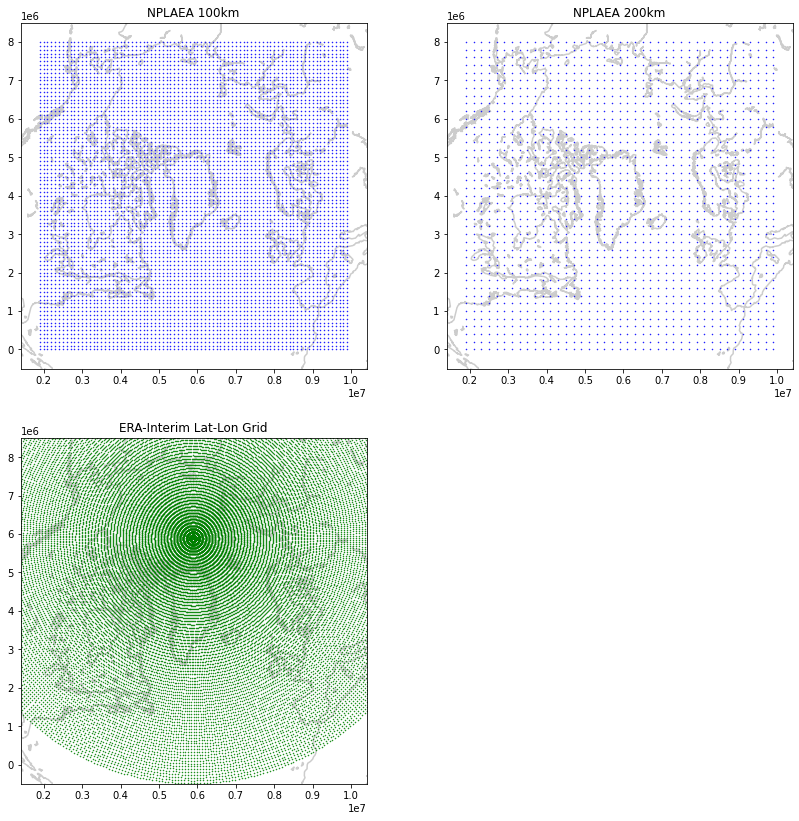

In [9]:
# Plot grids
def init_map(coast, axlims=None):
    plt.plot(coast['x'], coast['y'], '0.8', label='_nolegend_')
    plt.gca().set_aspect('equal')
    if axlims is not None:
        plt.xlim(axlims[:2])
        plt.ylim(axlims[2:])

markersize = 1
delta = 0.5e6
axlims = (xmin - delta, xmax + delta, ymin - delta, ymax + delta)

plt.figure(figsize=(14, 14))
iplot = 1
for nm, grid in grids.items():
    plt.subplot(2, 2, iplot)
    init_map(coast, axlims)
    plt.plot(grid['X'], grid['Y'], 'b.', markersize=markersize)
    plt.title('NPLAEA ' + nm)
    iplot +=1

plt.subplot(2, 2, iplot)
init_map(coast, axlims)
plt.plot(XM, YM, 'g.', markersize=markersize)
plt.title('ERA-Interim Lat-Lon Grid');